In [68]:
# | hidden: true
# | echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# some personal style settings to make the plots look nice
# and save some space in the notebook
plt.style.use("../style.mplstyle")

In the introductory lecture, we talked about the role of inference: drawing more general conclusions (about a population) from specific observations (a sample). Now that we have covered the most important building blocks, we can start to actually talk about how to make statistical inferences.

### The burden of proof
How can we use statistics to "prove" something? In diverse domains ranging from politics to sports, people often cite data as evidence. They may cherry-pick data that appears to support their argument, often constructing charts that highlight the point they want to make. You might hear statements like "the unemployment rate is lower than it was 4 years ago" or "player X has the highest scoring average in the league". These statistical facts can sound iron-clad, but they ignore the complexity of the underlying data and the uncertainty therein. They typically fail to acknowledge aspects of the data that do not support their argument, and they are rarely transparent about how the data was collected or analyzed.

For example, a politician might claim that their policies have led to a reduction in unemployment. Their support for this claim might be primarily based on a single statistic: "the unemployment rate is lower than it was 4 years ago". However, this statement does not provide any context or evidence that the politician's policies are actually responsible for the change.

Let's look at unemployment data from the US Bureau of Labor Statistics (BLS) ^[from [here](https://data.bls.gov/dataQuery/find?fq=survey:%5Bln%5D&s=popularity:D), accessed July 2025]

In [44]:
# | hidden: true
# | echo: false
# | eval: false
# data from https://data.bls.gov/dataQuery/find?fq=survey:%5Bln%5D&s=popularity:D
data = pd.read_csv("~/Downloads/file.csv")
data.to_csv("../data/unemployment-data-raw.csv", index=False)
series_id_map = {
    "LNS12300000": "unadj-unemployment-all",
    "LNS13024887": "seas-unemployment-16-24",
    "LNS14000000": "seas-unemployment-all",
    "LNS14000003": "seas-unemployment-white",
    "LNS14000006": "seas-unemployment-black",
    "LNS14000009": "seas-unemployment-hispanic",
    "LNU04000000": "seas-employment-population-all",
}
data["series_name"] = data["Series ID"].map(series_id_map)
data = data.rename(
    columns={
        "Series ID": "series_id",
        "Year": "year",
        "Period": "period",
        "Value": "value",
        "Label": "label",
    }
)
data["month"] = data["period"].str.replace("M", "").astype(int)
data = data.drop(columns=["period"])
data["date"] = pd.to_datetime(data[["year", "month"]].assign(day=1))
data.to_csv("../data/unemployment-data-cleaned.csv", index=False)

(0.0, 8.0)

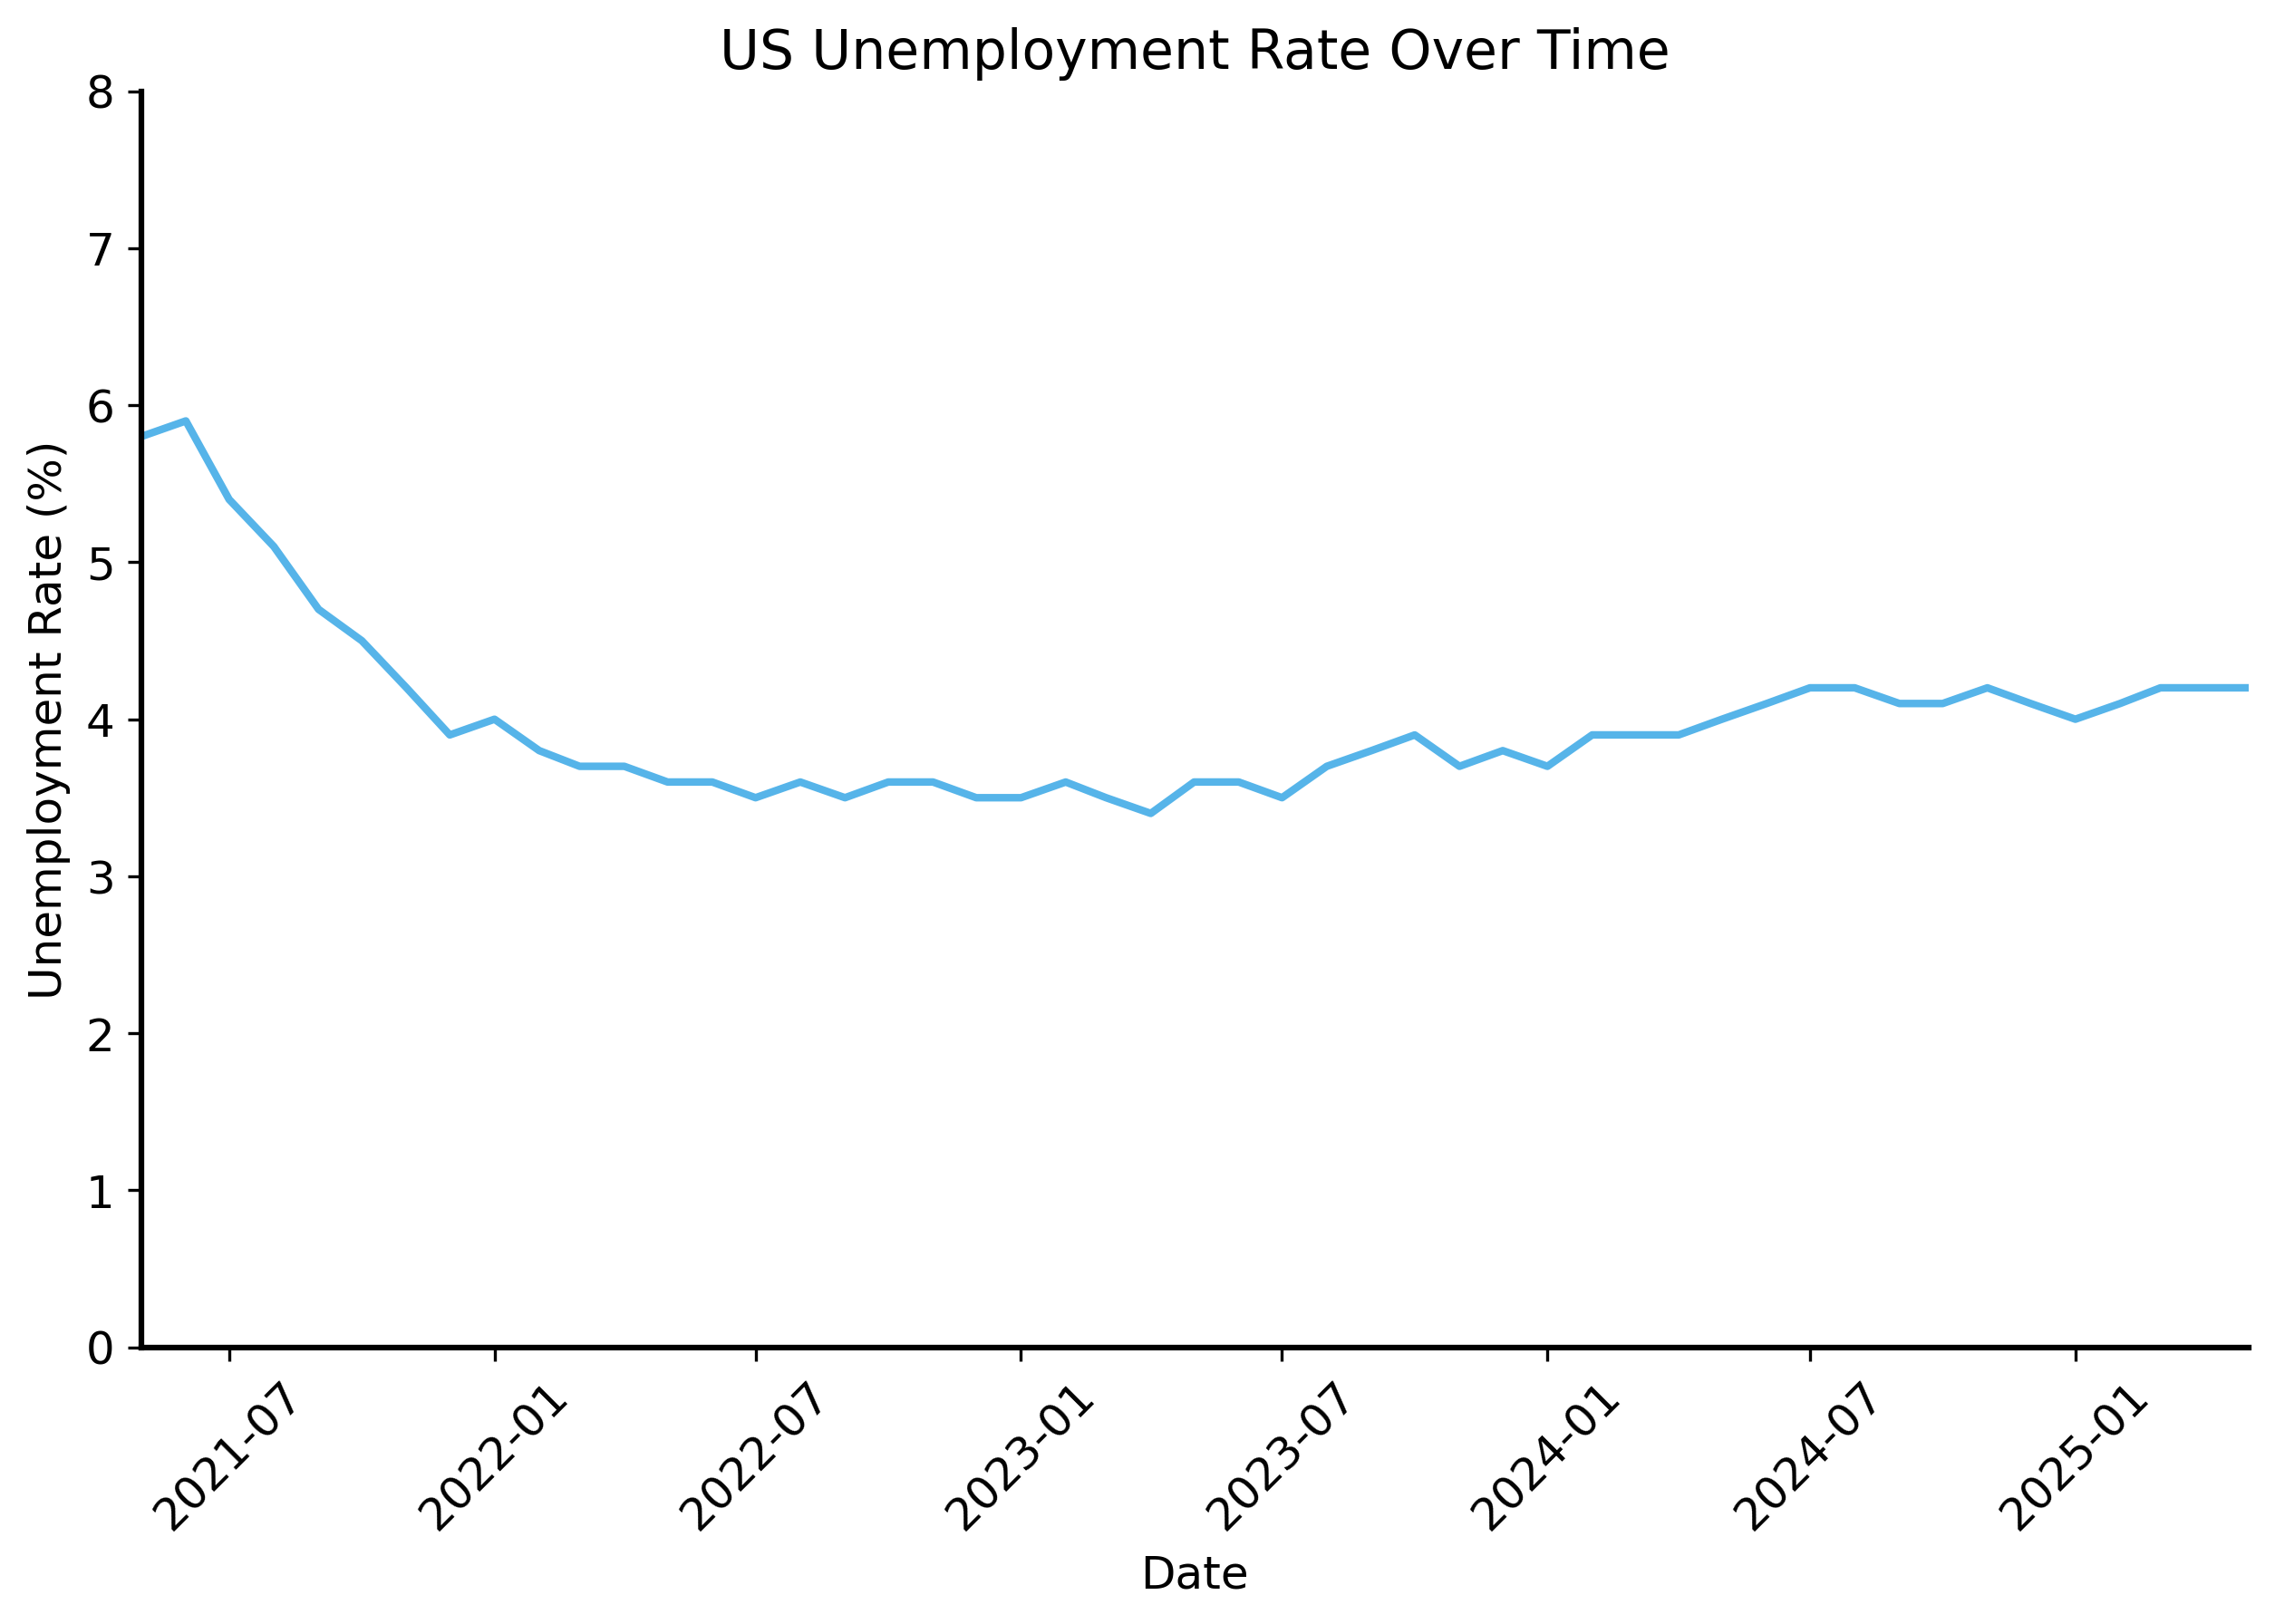

In [70]:
import datetime

data = pd.read_csv("../data/unemployment-data-cleaned.csv", parse_dates=["date"])
# pivot the data to have dates as index and series names as columns
wide_data = data.pivot(index="date", columns="series_name", values="value")

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=wide_data,
    x="date",
    y="seas-unemployment-all",
)
# format the x-axis to show dates nicely
plt.xticks(rotation=45)
plt.title("US Unemployment Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.xlim(datetime.date(2021, 5, 1), datetime.date(2025, 5, 1))
plt.ylim(0, 8)

What do you think? Are you convinced by the data presented? There's a pretty clear trend showing that unemployment decreased, as the politician claimed. It has basically leveled off in the last few years, but it is still lower than it was 4 years ago. 

To see one of the many things that the politician is not telling you, let's look at the unemployment rate over a longer time period.

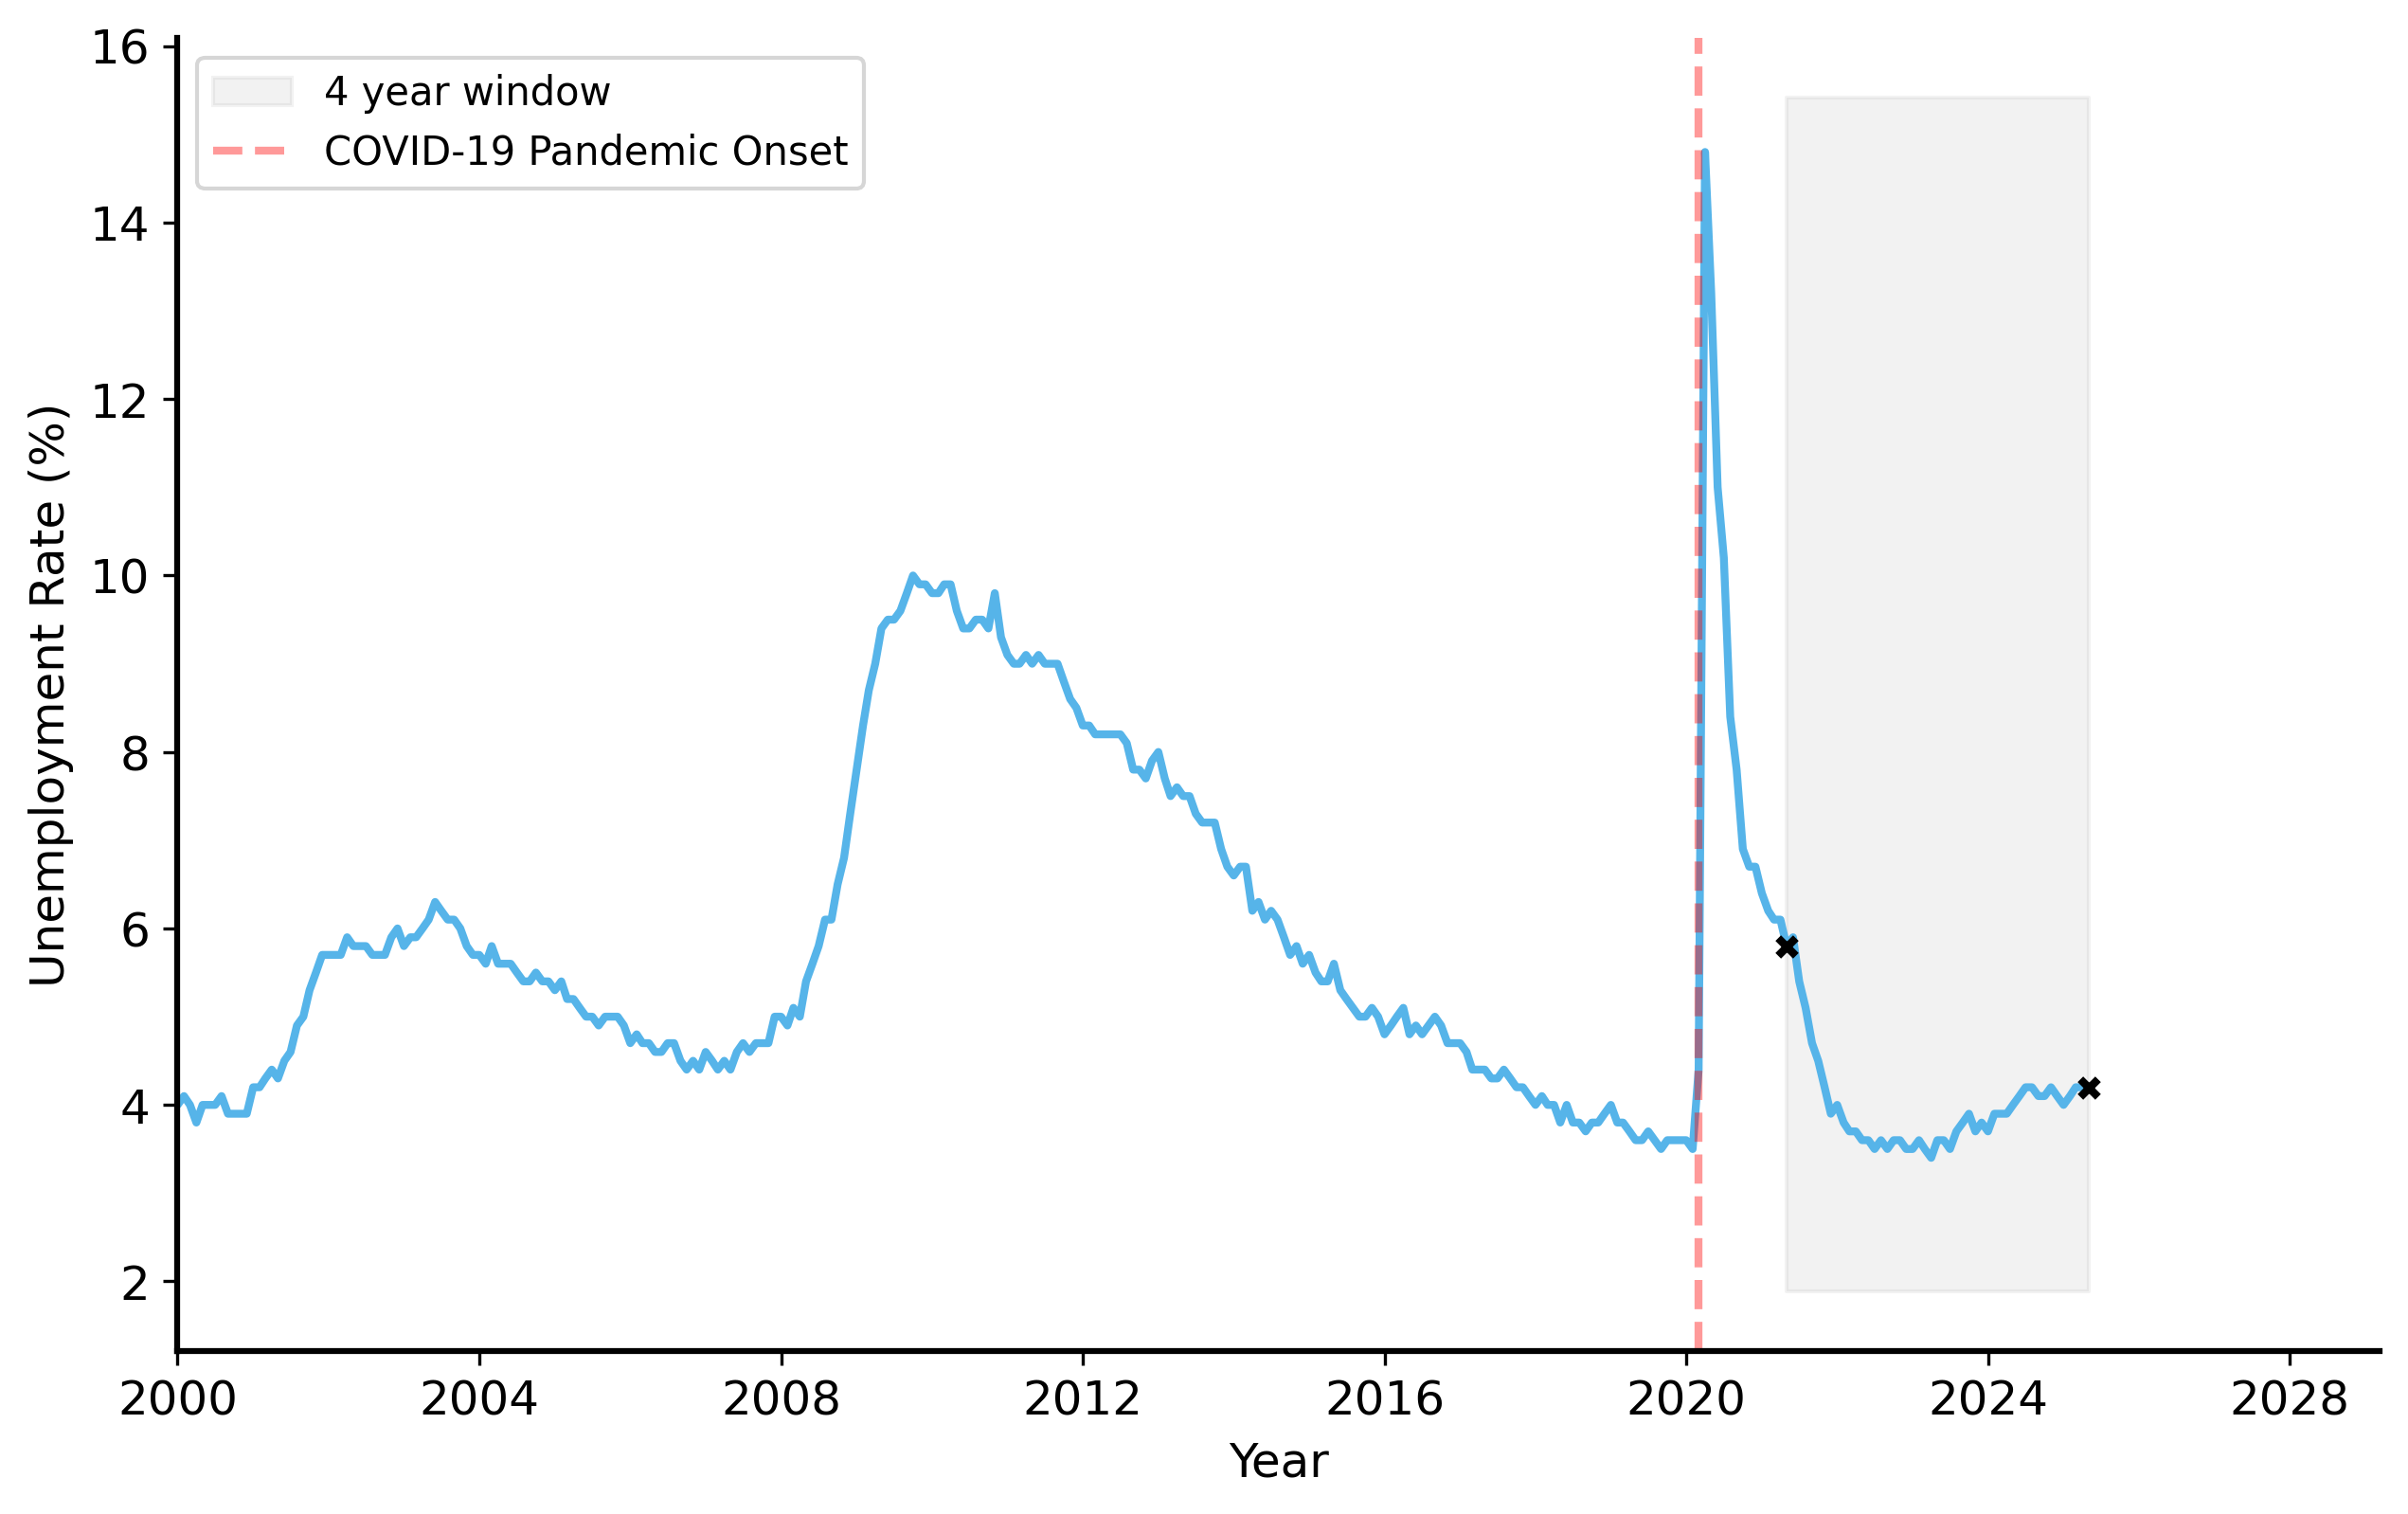

In [71]:
# plot the unemployment data
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=wide_data, x="date", y="seas-unemployment-all", ax=ax)
ax.fill_betweenx(
    ax.get_ylim(),
    datetime.datetime(2021, 5, 1),
    datetime.datetime(2025, 5, 1),
    color="gray",
    alpha=0.1,
    label="4 year window"
)
plt.scatter(
    x=[datetime.datetime(2021, 5, 1), datetime.datetime(2025, 5, 1)],
    y=[wide_data.loc[datetime.datetime(2021, 5, 1), "seas-unemployment-all"], wide_data.loc[datetime.datetime(2025, 5, 1), "seas-unemployment-all"]],
    color="black",
    s=20, zorder=2, marker='x'  
)
ax.axvline(datetime.datetime(2020, 3, 1), color="red", alpha=0.4, linestyle="--", label="COVID-19 Pandemic Onset")
ax.set_xlim(datetime.datetime(2000, 1, 1), None)
ax.set_ylabel("Unemployment Rate (%)")
ax.set_xlabel("Year")
ax.legend()
plt.show()

Hmmm. Suddenly the data looks a lot less convincing. Unemployment **spiked** in 2020 due to the COVID-19 pandemic, and by 2021 it was not yet back to pre-pandemic levels. This complicates the politician's claim. The decrease in unemployment over the last 4 years is not necessarily due to their policies, but rather a recovery from an unprecedented event.

If you changed the time period you were looking at, you could easily come to a different conclusion. For example, if you looked at the last 3 years or the last 6 years, you would see that unemployment actually increased. 

The key point is that *one should always be skeptical about data presented as evidence*. Data can be manipulated, cherry-picked, or misinterpreted to support a particular narrative. It's especially hard to evaluate the validity of a claim when the data is not presented in a transparent way. Because the world is so complicated, there are almost always alternative explanations for a given observation. In this case, the politician cited statistic can potentially be explained by external factors (like the pandemic) rather than their policies. 

To make matters worse, as we saw in the previous lecture, the data itself is not perfect. There is additional variability in the data generating process that we have not accounted for. You will notice that the unemployment rate is not a smooth line, but rather has some fluctuations. This is at least partly due to the fact that the data is collected from a sample of the population, and there is uncertainty in the estimates. ^[They survey around 50,000 housing units each month. See the BLS's [documentation](https://www.bls.gov/opub/hom/cps/design.htm#sample-size) for more information on the sample size and design of the Current Population Survey, which is used to estimate the unemployment rate.] How do we know that a change in the unemployment rate is not just due to random fluctuations in the data?

The **burden of proof** is on the person making the claim. If you want to convince someone that your claim is true, you need to provide evidence that supports it. 

:::{.callout-note title="Beyond a reasonable doubt?" collapse=true}
In a legal context, the phrase "beyond a reasonable doubt" refers to the standard of proof required to convict a defendant in a criminal trial (in the U.S.). It means that the evidence presented must be so convincing that there is no reasonable doubt left in the mind of a juror about the defendant's guilt. Of course you can never be 100% certain -- perhaps the defendant was being mind-controlled by aliens! -- but the evidence must be strong enough to convince a reasonable person that the defendant is guilty.
Any alternative explanations must be ruled out as implausible. This is a high standard of proof, reflecting the serious consequences of a criminal conviction. If the prosecution fails to meet this standard, the defendant is presumed innocent and acquitted of the charges.

In the context of statistical claims, we apply a similar standard of evidence. "Beyond a reasonable doubt" in our case means that 
the alternative explanations for the data are so unlikely (i.e. the probability of them being true is very small) that a reasonable person would simply ignore them. This is really a subjective judgment that is mostly about risk tolerance. 

What level of uncertainty are you willing to accept? Is it okay to be wrong 10% of the time? 5%? 1%? 0.1%? 
:::



### Formalizing hypotheses

One way to increase the transparency of empirical claims is to formalize them as hypotheses. A hypothesis is a specific, testable statement about the relationship between two or more variables. 

<!-- In academic research on everything from economics to medicine, the scientific method relies on proposing falsifiable hypotheses and testing them against data. Statistics plays a crucial role in this process by providing the tools to evaluate the strength of the evidence in support of these hypotheses. Perhaps you have heard the phrase "statistically significant" in the context of a research finding.  -->

At 